# Group E S2 - War-Twitter Analysis using Spark

# Sections
* [1. Setup](#1)
  * [1.1 Start Hadoop](#1.1)  
  * [1.2 Search for Spark Installation](#1.2)
  * [1.3 Create SparkSession](#1.3)
* [2. Analysis](#2)
  * [2.1 Check Covid19-Twitter Files and import libraries](#2.1)
  * [2.2 Create the DataFrame](#2.3)
  * [2.3 Shorcut for the streaming part](#2.3)
* [3. Transforming Tweets & Initial Analysis](#3)
  * [3.1 Transforming Tweets_original dataframe](#3.1)
  * [3.2 Initial Analysis](#3.2)

  

<a id='1'></a>
## 1. Setup

Since we are going to process data stored from HDFS let's start the service

<a id='1.1'></a>
### 1.1 Start Hadoop

Start Hadoop

Open a terminal and execute
```sh
hadoop-start.sh
```

<a id='1.2'></a>
### 1.2 Search for Spark Installation 
This step is required just because we are working in the course environment.

In [2]:
import findspark
findspark.init()

I'm changing pandas max column width property to improve data displaying

In [3]:
import pandas as pd
pd.set_option('display.max_colwidth', None)

<a id='1.3'></a>
### 1.3 Create SparkSession

We can include extra libraries in our Spark cluster

In [4]:
import os
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages "graphframes:graphframes:0.8.2-spark3.2-s_2.12" --jars /opt/hive3/lib/hive-hcatalog-core-3.1.2.jar pyspark-shell'
#os.environ['PYSPARK_SUBMIT_ARGS'] = '--jars /opt/hive3/lib/hive-hcatalog-core-3.1.2.jar pyspark-shell'

The first thing always is to create the SparkSession

In [5]:
from pyspark.sql.session import SparkSession

spark = (SparkSession.builder
    .appName("Final_DataFrames(1)")
    .config("spark.sql.warehouse.dir","hdfs://localhost:9000/warehouse")
    .config("spark.sql.legacy.timeParserPolicy","LEGACY")
    .enableHiveSupport()
    .getOrCreate())

Ivy Default Cache set to: /home/osbdet/.ivy2/cache
The jars for the packages stored in: /home/osbdet/.ivy2/jars
:: loading settings :: url = jar:file:/opt/spark3/jars/ivy-2.4.0.jar!/org/apache/ivy/core/settings/ivysettings.xml
graphframes#graphframes added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-cd8ee9a4-5347-440c-a193-8227bdf53f82;1.0
	confs: [default]
	found graphframes#graphframes;0.8.2-spark3.2-s_2.12 in spark-packages
	found org.slf4j#slf4j-api;1.7.16 in central
:: resolution report :: resolve 222ms :: artifacts dl 5ms
	:: modules in use:
	graphframes#graphframes;0.8.2-spark3.2-s_2.12 from spark-packages in [default]
	org.slf4j#slf4j-api;1.7.16 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	------------------------------------------------------------

<a id='2'></a>
## 2. Analysis

<a id='2.1'></a>
### 2.1 Check War-Twitter Files

To be able to transform and get insights from our data we need to transform them from the raw layer (bronce) to the standard layer (silver). To do that, we use the notebook **'War - RAW to STD - DataFrames'**.

Once we promote the data, they are storage here:

http://localhost:50070/explorer.html#/datalake/std/twitter/War/

The first point is to import all the libraries that we could use:

In [6]:
from shutil import make_archive

make_archive('tweets_war.zip', 'zip', "tweets_war.parquet")

'/home/osbdet/notebooks/Group_project/tweets_war.zip.zip'

In [7]:
import matplotlib
import matplotlib.pyplot as plt # for visualization
import seaborn as sns # for visualization
import findspark
findspark.init()
#from pyspark.sql.functions import *
from pyspark.sql.functions import split, explode, size, col, asc, desc
from pyspark.sql.functions import UserDefinedFunction
from datetime import datetime
import pytz
import pandas as pd
import os
from pyspark.sql.session import SparkSession
import re # for regular expression
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from collections import Counter 
matplotlib.style.use('ggplot')
%matplotlib inline

<a id='2.2'></a>
### 2.2 Create the DataFrame

The first step after creating the SparkSession is to create one or more DataFrames<br/>
The data in the std layer is often stored in advanced storage formats like **parquet**.<br/>
These formats have the schema of the data embedded inside the file

In [8]:
tweets_original = (spark.read
               .parquet("hdfs://localhost:9000/datalake/std/twitter/War/year=2022"))

We can check the original schema defined when we upgraded from raw to standard.

In [9]:
tweets_original.printSchema()

root
 |-- created_at: timestamp (nullable = true)
 |-- id_str: string (nullable = true)
 |-- text: string (nullable = true)
 |-- user: struct (nullable = true)
 |    |-- id_str: string (nullable = true)
 |    |-- name: string (nullable = true)
 |    |-- screen_name: string (nullable = true)
 |    |-- location: string (nullable = true)
 |    |-- description: string (nullable = true)
 |    |-- followers_count: long (nullable = true)
 |    |-- friends_count: long (nullable = true)
 |    |-- listed_count: long (nullable = true)
 |    |-- favourites_count: long (nullable = true)
 |    |-- statuses_count: long (nullable = true)
 |    |-- created_at: string (nullable = true)
 |    |-- verified: boolean (nullable = true)
 |-- retweeted_status: struct (nullable = true)
 |    |-- quot_count: integer (nullable = true)
 |    |-- reply_count: integer (nullable = true)
 |    |-- retweet_count: integer (nullable = true)
 |    |-- favorite_count: integer (nullable = true)
 |    |-- user: struct (nulla

<a id='2.3'></a>
**2.3 Shorcut/Trick for stream processing**<br/>

**For the streaming part, as we donot connect to a real live database, we took the decision of creating a txt file with all the information within the original schema. For the purpose of the streaming analysis and to ease data management we decided to unstack the embedded structure defining a new dataframe with the following schema.**<br/>

In [10]:
from pyspark.sql.functions import StringType
tweets_to_text = tweets_original\
                        .withColumn('created_at',tweets_original['created_at'])\
                        .withColumn('id_str', tweets_original['id_str'])\
                        .withColumn('user_name', tweets_original['user']['name'])\
                        .withColumn('user_id', tweets_original['user']['id_str'])\
                        .withColumn('user_screen_name', tweets_original['user']['screen_name'])\
                        .withColumn('user_location', tweets_original['user']['location'])\
                        .withColumn('user_description', tweets_original['user']['description'])\
                        .withColumn('user_followers_count',tweets_original['user']['followers_count'])\
                        .withColumn('user_friends_count', tweets_original['user']['friends_count'])\
                        .withColumn('user_listed_count', tweets_original['user']['listed_count'])\
                        .withColumn('user_favourites_count', tweets_original['user']['favourites_count'])\
                        .withColumn('user_statuses_count', tweets_original['user']['statuses_count'])\
                        .drop(tweets_original['user'])\
                        .withColumn('rt_quot_count', tweets_original['retweeted_status']['quot_count'])\
                        .withColumn('rt_reply_count', tweets_original['retweeted_status']['reply_count'])\
                        .withColumn('rt_retweet_count', tweets_original['retweeted_status']['retweet_count'])\
                        .withColumn('rt_favorite_count', tweets_original['retweeted_status']['favorite_count'])\
                        .withColumn('rt_user_id',tweets_original['retweeted_status']['user']['id_str'])\
                        .withColumn('rt_user_name', tweets_original['retweeted_status']['user']['name'])\
                        .withColumn('rt_user_screen_name', tweets_original['retweeted_status']['user']['screen_name'])\
                        .withColumn('rt_user_location', tweets_original['retweeted_status']['user']['location'])\
                        .withColumn('rt_user_description', tweets_original['retweeted_status']['user']['description'])\
                        .withColumn('rt_user_followers_count',tweets_original['retweeted_status']['user']['followers_count'])\
                        .withColumn('rt_user_friends_count', tweets_original['retweeted_status']['user']['friends_count'])\
                        .withColumn('rt_user_listed_count', tweets_original['retweeted_status']['user']['listed_count'])\
                        .withColumn('rt_user_favourites_count', tweets_original['retweeted_status']['user']['favourites_count'])\
                        .withColumn('rt_user_listed_count', tweets_original['retweeted_status']['user']['listed_count'])\
                        .withColumn('rt_user_favourites_count',tweets_original['retweeted_status']['user']['favourites_count'])\
                        .withColumn('rt_user_statuses_count', tweets_original['retweeted_status']['user']['statuses_count'])\
                        .withColumn('rt_user_created_at', tweets_original['retweeted_status']['user']['created_at'])\
                        .withColumn('user_mentions_screen_name', tweets_original['entities']['user_mentions']['screen_name'])\
                        .withColumn('hashtags', tweets_original['entities']['hashtags']['text'])\
                        .withColumn('media_expanded_url', tweets_original['entities']['media']['expanded_url'])\
                        .withColumn('urls_expanded_url', tweets_original['entities']['urls']['expanded_url'])\
                        .withColumn('symbols_text', tweets_original['entities']['symbols']['text'])\
                        .drop(tweets_original['retweeted_status'])\
                        .drop(tweets_original['place'])\
                        .drop(tweets_original['entities'])\
                        .drop(tweets_original['retweeted_status'])\

In [11]:
tweets_to_text.toPandas()

,created_at,id_str,text,quote_count,reply_count,retweet_count,favorite_count,favorited,retweeted,possibly_sensitive,...,rt_user_friends_count,rt_user_listed_count,rt_user_favourites_count,rt_user_statuses_count,rt_user_created_at,user_mentions_screen_name,hashtags,media_expanded_url,urls_expanded_url,symbols_text
0,2022-02-27 13:08:48,1497906560814796801,"RT @mbk_center: Putin's invasion of Ukraine🇺🇦 has sparked a host of anti-war demonstrations in cities around the world, including Russia 🇷🇺…",0,0,0,0,False,False,None,...,1664.0,702.0,17519.0,35576.0,Wed Oct 07 19:03:44 +0000 2009,[mbk_center],[],None,[],[]
1,2022-02-27 13:08:48,1497906561049583620,"RT @load_pm: 💪Зараз у Хмельницькому жінки та діти плетуть маскувальні сітки, щоб допомогти нашим героям. Всі українці, від малого до велико…",0,0,0,0,False,False,None,...,14.0,21.0,108.0,395.0,Fri Aug 10 18:52:27 +0000 2018,[load_pm],[],None,[],[]
2,2022-02-27 13:08:48,1497906561058062340,RT @Raebo56: Don’t let the Russia invasion of Ukraine allow you to be distracted from the fact that \nJustin Trudeau and Jagmeet Singh just…,0,0,0,0,False,False,None,...,594.0,1.0,3086.0,7581.0,Thu Dec 02 04:31:03 +0000 2021,[Raebo56],[],None,[],[]
3,2022-02-27 13:08:48,1497906561074741250,RT @DavidLaufmanLaw: Correction: It wasn’t “the Trump Administration” that required RT’s U.S. affiliate to register under the Foreign Agent…,0,0,0,0,False,False,None,...,1286.0,259.0,3553.0,991.0,Mon Aug 27 22:28:07 +0000 2018,[DavidLaufmanLaw],[],None,[],[]
4,2022-02-27 13:08:48,1497906560932134913,"RT @PessimismeActif: Oui, l’Ukraine est plus chère et proche à nos cœurs que l’Afghanistan ou le Togo.\n\nEt on s’excusera de rien du tout.",0,0,0,0,False,False,None,...,307.0,1.0,3613.0,2438.0,Tue Dec 28 19:06:21 +0000 2021,[PessimismeActif],[],None,[],[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127559,2022-03-02 18:27:52,1499074020708610049,@ShapooIshan comment for better reach.\n\nsending prayers and hope\nFOLLOW for more\nPLEASE WATCH THIS VIDEO\n#Ukriane… https://t.co/GmMlOKScF9,0,0,0,0,False,False,False,...,NaN,NaN,NaN,NaN,None,[ShapooIshan],[Ukriane],None,[https://twitter.com/i/web/status/1499074020708610049],[]
127560,2022-03-02 18:27:52,1499074020804808704,RT @TheRickWilson: Putin has unified Europe like little else.\n\nStrong statement.,0,0,0,0,False,False,None,...,6568.0,9253.0,100562.0,341835.0,Fri Jan 16 20:50:17 +0000 2009,[TheRickWilson],[],None,[],[]
127561,2022-03-02 18:27:52,1499074020930588673,"RT @littlebluerebe1: Go to Google, look up Moscow Russia restaurants and leave Google reviews letting the people of Russia know what’s goin…",0,0,0,0,False,False,None,...,5448.0,3.0,45164.0,20088.0,Tue Jan 22 22:01:40 +0000 2019,[littlebluerebe1],[],None,[],[]
127562,2022-03-02 18:27:52,1499074020737634304,RT @bettapique: Escenas de destrucción a los pies de la torre de tv de Kiev #UkraineUnderAttack https://t.co/6yaiM1BFzq,0,0,0,0,False,False,False,...,2154.0,662.0,5906.0,38329.0,Tue Nov 09 11:41:25 +0000 2010,[bettapique],[UkraineUnderAttack],[https://twitter.com/bettapique/status/1498932231225716743/video/1],[],[]


**Here can be seen the flat structure schema we defined of our new dataframe to ease its manage in the streaming part**

In [12]:
tweets_to_text.printSchema()

root
 |-- created_at: timestamp (nullable = true)
 |-- id_str: string (nullable = true)
 |-- text: string (nullable = true)
 |-- quote_count: long (nullable = true)
 |-- reply_count: long (nullable = true)
 |-- retweet_count: long (nullable = true)
 |-- favorite_count: long (nullable = true)
 |-- favorited: boolean (nullable = true)
 |-- retweeted: boolean (nullable = true)
 |-- possibly_sensitive: boolean (nullable = true)
 |-- filter_level: string (nullable = true)
 |-- lang: string (nullable = true)
 |-- hour: integer (nullable = true)
 |-- mix: string (nullable = true)
 |-- dt: date (nullable = true)
 |-- day-hour: string (nullable = true)
 |-- user_name: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- user_screen_name: string (nullable = true)
 |-- user_location: string (nullable = true)
 |-- user_description: string (nullable = true)
 |-- user_followers_count: long (nullable = true)
 |-- user_friends_count: long (nullable = true)
 |-- user_listed_count: long 

**Last step to create a txt document copy to use later as streaming source.**<br/>

In [13]:
tweets_to_text_final = tweets_to_text.toPandas()

In [14]:
tweets_to_text_final.to_csv("tweets_war.txt", header=True, sep = '|', index=False, mode = 'w')

<a id='3'></a>
### 3 Transforming Tweets & Initial Analysis

<a id='3.1'></a>
#### 3.1 Transforming Tweets_original dataframe with some new columns for processing**<br/>

In [15]:
tweets = tweets_original\
             .withColumn("created_at",F.to_timestamp(F.col("created_at"),"EEE MMM dd HH:mm:ss ZZZZZ yyyy"))\
             .withColumn("year",F.year("created_at"))\
             .withColumn("dt",F.to_date("created_at"))\
             .withColumn("hour",F.hour("created_at"))\
             .withColumn("day-hour",F.concat_ws("-",F.to_date("created_at"),F.hour("created_at")))
                
tweets.limit(5).toPandas()


,created_at,id_str,text,user,retweeted_status,place,quote_count,reply_count,retweet_count,favorite_count,...,favorited,retweeted,possibly_sensitive,filter_level,lang,hour,mix,dt,day-hour,year
0,2022-02-27 13:08:48,1497906560814796801,"RT @mbk_center: Putin's invasion of Ukraine🇺🇦 has sparked a host of anti-war demonstrations in cities around the world, including Russia 🇷🇺…","(716733642488299520, Abęfę🤴, abefe007, Ogun, Nigeria, Graphics Designer | Travel and Tour consultant | Man United Fan⚽ | Music Lover | Movie lover.... I always Follow Back✌️, 188, 1091, 0, 4075, 3347, Sun Apr 03 21:06:31 +0000 2016, False)","(None, 16, 107, 588, (80653307, Mikhail Khodorkovsky (English), mbk_center, London, Mikhail Khodorkovsky @mich261213 Twitter Account in English, 28401, 1664, 702, 17519, 35576, Wed Oct 07 19:03:44 +0000 2009))",None,0,0,0,0,...,False,False,None,low,en,13,None,2022-02-27,2022-02-27-13,2022
1,2022-02-27 13:08:48,1497906561049583620,"RT @load_pm: 💪Зараз у Хмельницькому жінки та діти плетуть маскувальні сітки, щоб допомогти нашим героям. Всі українці, від малого до велико…","(803387388533899264, Piotr, Grado_Wwa, None, None, 1, 14, 0, 37, 7, Mon Nov 28 23:57:34 +0000 2016, False)","(None, 0, 1, 12, (1027991081584144386, nws, load_pm, UA Кременчук, 2022 Russian invasion of Ukraine, 1652, 14, 21, 108, 395, Fri Aug 10 18:52:27 +0000 2018))",None,0,0,0,0,...,False,False,None,low,uk,13,None,2022-02-27,2022-02-27-13,2022
2,2022-02-27 13:08:48,1497906561058062340,RT @Raebo56: Don’t let the Russia invasion of Ukraine allow you to be distracted from the fact that \nJustin Trudeau and Jagmeet Singh just…,"(962762606766317568, Sheila J, Sheilaanne2191, Montreal, Married, one adult son and a beautiful dog named Lily. Love all creatures except some humans I know:) Very into Canadian, British and U.S. politics., 525, 1225, 4, 53826, 31286, Sun Feb 11 18:57:47 +0000 2018, False)","(None, 17, 184, 440, (1466263472132423681, Raebo, Raebo56, Alberta, Canada, Albertan, Secessionist, Political Activist, Conservative, Business Owner, Patent Holder, Inventor, Jack Russells, Aviation, Cosmetic Chemistry, Photography, 562, 594, 1, 3086, 7581, Thu Dec 02 04:31:03 +0000 2021))",None,0,0,0,0,...,False,False,None,low,en,13,None,2022-02-27,2022-02-27-13,2022
3,2022-02-27 13:08:48,1497906561074741250,RT @DavidLaufmanLaw: Correction: It wasn’t “the Trump Administration” that required RT’s U.S. affiliate to register under the Foreign Agent…,"(1267915607804194817, TerryDean, TerryDe53425222, New York, USA, expat returned after little over 20 years. Trying to understand what’s going on?!?, 49, 120, 0, 47309, 6838, Tue Jun 02 20:27:08 +0000 2020, False)","(None, 4, 111, 433, (1034205948007645184, David Laufman, DavidLaufmanLaw, Washington, DC, Representation in gov’t investigations and national security matters. Former Chief of DOJ Counterintelligence Section. Stalwart Houston Astros fan. Views my own, 29303, 1286, 259, 3553, 991, Mon Aug 27 22:28:07 +0000 2018))",None,0,0,0,0,...,False,False,None,low,en,13,None,2022-02-27,2022-02-27-13,2022
4,2022-02-27 13:08:48,1497906560932134913,"RT @PessimismeActif: Oui, l’Ukraine est plus chère et proche à nos cœurs que l’Afghanistan ou le Togo.\n\nEt on s’excusera de rien du tout.","(1956489876, lemmerdeuse 🇫🇷🇮🇱Z, lemmerdeuse24, Aquitaine, France, TOUS A VOS TEE SHIRT pour \nLIBERTE - EGALITE - FRATERNITE -\nRUES DE FRANCES LAÏQUES -\nLA RELIGION A LA MAISON -\nPOUR UNE FRANCE EN PAIX et SANS DISCREMINATION, 1280, 1619, 14, 18668, 22247, Sat Oct 12 12:13:06 +0000 2013, False)","(None, 14, 33, 154, (1475905928511766532, Alexandre 𓅨𓂋𓀀, PessimismeActif, Paris, France, Chats, Géopolitique & Pessimisme | moi/je, 1125, 307, 1, 3613, 2438, Tue Dec 28 19:06:21 +0000 2021))",None,0,0,0,0,...,False,False,None,low,fr,13,None,2022-02-27,2022-02-27-13,2022


<a id='3.2'></a>
#### 3.2 Initial Analysis

**Total number of tweets**<br/>

In [16]:
total = tweets.count()
total

127564

**Total number of distinct users**<br/>

In [17]:
tweets.select("user.name").distinct().count()

100876

#### The summary statistics of the most relevant numeric features

In [18]:
tweets.select("user.statuses_count","retweeted","user.favourites_count","user.friends_count",'user.followers_count').summary().toPandas()

,summary,statuses_count,favourites_count,friends_count,followers_count
0,count,127564,127564,127564,127564
1,mean,52583.14569157443,49760.14121538992,1651.5344376156281,12580.519637201718
2,stddev,120315.78116996291,96347.10901621134,5059.006820039178,403273.7791551244
3,min,1,0,0,0
4,25%,2180,2010,176,64
5,50%,12506,13275,575,328
6,75%,50257,53712,1732,1351
7,max,3429639,1705383,590033,56688383


### Distribution Plot
We only take values bellow the percentile 75 to facilitate the visualization, since it's very right skewed.

In [19]:
#pip install spark_plot

array([<AxesSubplot:title={'center':'followers'}>], dtype=object)

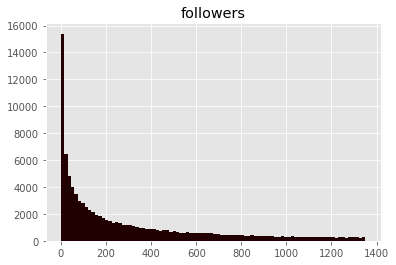

In [20]:
from spark_plot import mpl

#percentile 75 of the followers count
foll_75 = tweets.withColumn("followers", F.col("user.followers_count")).withColumn("verified", F.col("user.verified")).select("user.followers_count").summary().toPandas().iloc[6][1]
foll_75

#tweets.withColumn("followers", F.col("user.followers_count"))
mpl.hist(tweets.withColumn("followers", F.col("user.followers_count")).withColumn("verified", F.col("user.verified")).filter(F.col("followers")<foll_75), 
         "followers", color="#200000", 
         bins = 90)

We can see how the amount of uses decreases when the followers count increases.

### Alternative distribution plot

Another way to take an aproximate look at the distribution, considering a potentially big amount of data, would be sampling the dataset and do it directly with python libraries.

Doing so, let's compare the density distribution of both sets.

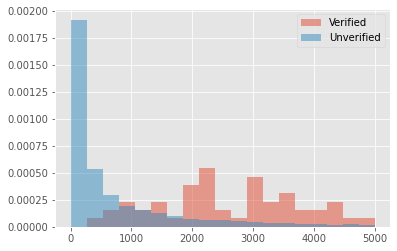

In [21]:
import numpy as np
samples = tweets.withColumn("followers", F.col("user.followers_count")).withColumn("verified", F.col("user.verified")).sample(fraction = 0.1).toPandas()

bins = np.linspace(0, 5000, 20)
plt.hist(samples[samples["verified"]==1]["followers"], bins, alpha=0.5, label='Verified', density=True)
plt.hist(samples[samples["verified"]==0]["followers"], bins, alpha=0.5, label='Unverified',density=True)
plt.legend(loc='upper right')
plt.show()

**Total number of tweets per language**<br/>

In [22]:
(tweets
      .groupBy("lang")
      .agg(F.count("*").alias("total"))).toPandas()

,lang,total
0,en,110808
1,uk,377
2,de,4436
3,es,1843
4,ru,713
5,fr,9387


**Top 20 more popular emojis**<br/>

In [23]:
from pyspark.sql.functions import udf

import emojis

@udf("array<string>")
def get_emojis_udf(s):
    set = emojis.get(s)
    return [*set, ]

tweets.select(explode(get_emojis_udf("text")).alias("emoji"))\
      .groupBy("emoji").agg(F.count("*").alias("total")).orderBy(desc("total")).limit(20)\
      .toPandas()

,emoji,total
0,🇺🇦,5744
1,⚡,2135
2,🇷🇺,1433
3,🇯🇵,735
4,🙏,669
5,🚨,565
6,👇,516
7,🔴,501
8,😂,365
9,❤️,362


In [24]:
import itertools
import collections
import tweepy as tw
import nltk
from nltk.corpus import stopwords
import re
import networkx
import warnings

**Top popular words in the tweet text**

In [25]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/osbdet/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [26]:
tweets_df = tweets.toPandas()

In [27]:
stop_words = list(stopwords.words('english')) + list(stopwords.words('spanish'))

stop_words_final = stop_words.append("rt")
stop_words_final2 = stop_words.append("-")
words_in_tweet = [tweet.lower().split() for tweet in tweets_df["text"]]

all_words_no_urls = list(itertools.chain(*words_in_tweet))
words2 = [word for word in all_words_no_urls if word not in stop_words]
counts_no_urls = collections.Counter(words2)
counts_no_urls.most_common()

[('ukraine', 29809),
 ('russia', 17567),
 ('russian', 14241),
 ('#ukraine', 7375),
 ('war', 7284),
 ('people', 6583),
 ('putin', 6144),
 ('ukraine.', 6074),
 ('ukrainian', 5334),
 ('&amp;', 4502),
 ('president', 4379),
 ('us', 3819),
 ('ukraine,', 3747),
 ('world', 3517),
 ('support', 3389),
 ('🇺🇦', 3187),
 ('invasion', 3140),
 ('à', 2960),
 ('says', 2852),
 ('die', 2794),
 ('one', 2789),
 ('stop', 2769),
 ('like', 2746),
 ('russia.', 2720),
 ("russia's", 2697),
 ('would', 2586),
 ('military', 2548),
 ('der', 2515),
 ('des', 2494),
 ('et', 2474),
 ('help', 2421),
 ('breaking:', 2272),
 ('eu', 2096),
 ('@zelenskyyua:', 2075),
 ('nato', 2063),
 ('#ukraine.', 2026),
 ('minister', 2002),
 ('@kyivindependent:', 1984),
 ('students', 1964),
 ('zelensky', 1957),
 ('indian', 1953),
 ('country', 1951),
 ('forces', 1861),
 ('must', 1840),
 ('sanctions', 1839),
 ('#russia', 1833),
 ('russia’s', 1831),
 ('time', 1819),
 ('today', 1808),
 ('it’s', 1776),
 ('nuclear', 1768),
 ('new', 1757),
 ('need',

<a id='4'></a>
### 4 Graph Analysis

**Creating the Graph: Users are Vertices, and Mentions are the Edges**

In [28]:
tweets_ukraine = tweets

In [29]:
tweets_ukraine.printSchema()

root
 |-- created_at: timestamp (nullable = true)
 |-- id_str: string (nullable = true)
 |-- text: string (nullable = true)
 |-- user: struct (nullable = true)
 |    |-- id_str: string (nullable = true)
 |    |-- name: string (nullable = true)
 |    |-- screen_name: string (nullable = true)
 |    |-- location: string (nullable = true)
 |    |-- description: string (nullable = true)
 |    |-- followers_count: long (nullable = true)
 |    |-- friends_count: long (nullable = true)
 |    |-- listed_count: long (nullable = true)
 |    |-- favourites_count: long (nullable = true)
 |    |-- statuses_count: long (nullable = true)
 |    |-- created_at: string (nullable = true)
 |    |-- verified: boolean (nullable = true)
 |-- retweeted_status: struct (nullable = true)
 |    |-- quot_count: integer (nullable = true)
 |    |-- reply_count: integer (nullable = true)
 |    |-- retweet_count: integer (nullable = true)
 |    |-- favorite_count: integer (nullable = true)
 |    |-- user: struct (nulla

In [30]:
mentions = tweets_ukraine.select(col("user.screen_name").alias("user_name"),"text",col("entities.user_mentions.screen_name").alias("mentions"))
mentions.limit(5).show()

+---------------+--------------------+-----------------+
|      user_name|                text|         mentions|
+---------------+--------------------+-----------------+
|       abefe007|RT @mbk_center: P...|     [mbk_center]|
|      Grado_Wwa|RT @load_pm: 💪За...|        [load_pm]|
| Sheilaanne2191|RT @Raebo56: Don’...|        [Raebo56]|
|TerryDe53425222|RT @DavidLaufmanL...|[DavidLaufmanLaw]|
|  lemmerdeuse24|RT @PessimismeAct...|[PessimismeActif]|
+---------------+--------------------+-----------------+



In [31]:
# change the user_name & mentions to uppercase
mentions = mentions.withColumn("user_name", F.upper(F.col("user_name")))
mentions = mentions.withColumn("mentions", F.upper(F.col("mentions")[0]))

mentions.limit(5).toPandas()

,user_name,text,mentions
0,ABEFE007,"RT @mbk_center: Putin's invasion of Ukraine🇺🇦 has sparked a host of anti-war demonstrations in cities around the world, including Russia 🇷🇺…",MBK_CENTER
1,GRADO_WWA,"RT @load_pm: 💪Зараз у Хмельницькому жінки та діти плетуть маскувальні сітки, щоб допомогти нашим героям. Всі українці, від малого до велико…",LOAD_PM
2,SHEILAANNE2191,RT @Raebo56: Don’t let the Russia invasion of Ukraine allow you to be distracted from the fact that \nJustin Trudeau and Jagmeet Singh just…,RAEBO56
3,TERRYDE53425222,RT @DavidLaufmanLaw: Correction: It wasn’t “the Trump Administration” that required RT’s U.S. affiliate to register under the Foreign Agent…,DAVIDLAUFMANLAW
4,LEMMERDEUSE24,"RT @PessimismeActif: Oui, l’Ukraine est plus chère et proche à nos cœurs que l’Afghanistan ou le Togo.\n\nEt on s’excusera de rien du tout.",PESSIMISMEACTIF


In [32]:
#removing null mentions
mentions = mentions.where(col("mentions").isNotNull())
mentions.limit(5).toPandas()

,user_name,text,mentions
0,ABEFE007,"RT @mbk_center: Putin's invasion of Ukraine🇺🇦 has sparked a host of anti-war demonstrations in cities around the world, including Russia 🇷🇺…",MBK_CENTER
1,GRADO_WWA,"RT @load_pm: 💪Зараз у Хмельницькому жінки та діти плетуть маскувальні сітки, щоб допомогти нашим героям. Всі українці, від малого до велико…",LOAD_PM
2,SHEILAANNE2191,RT @Raebo56: Don’t let the Russia invasion of Ukraine allow you to be distracted from the fact that \nJustin Trudeau and Jagmeet Singh just…,RAEBO56
3,TERRYDE53425222,RT @DavidLaufmanLaw: Correction: It wasn’t “the Trump Administration” that required RT’s U.S. affiliate to register under the Foreign Agent…,DAVIDLAUFMANLAW
4,LEMMERDEUSE24,"RT @PessimismeActif: Oui, l’Ukraine est plus chère et proche à nos cœurs que l’Afghanistan ou le Togo.\n\nEt on s’excusera de rien du tout.",PESSIMISMEACTIF


In [33]:
from graphframes import GraphFrame

In [34]:
vertices = (mentions.withColumnRenamed("user_name","id")
           .distinct())
        
edges = (mentions
            .withColumnRenamed("user_name","src")
            .withColumnRenamed("mentions","dst")
            .groupBy("src","dst")
            .agg(
                F.count("*").alias("occurrences")
            ))
graph = GraphFrame(vertices, edges)
graph.cache()

GraphFrame(v:[id: string, text: string ... 1 more field], e:[src: string, dst: string ... 1 more field])

In [35]:
# How many users?
vertices.count()

111830

In [36]:
# How many mentions?
edges.count()

109341

In [37]:
#Top 5 mentions per user
graph.edges.orderBy(desc("occurrences")).limit(5).toPandas()
#KNN Was mentioned 8 times

,src,dst,occurrences
0,SOUTH_IRAQI,A7_MIRZA,13
1,IHRUTSIV,EMMANUELMACRON,11
2,DASISUMI,BHERULA06341772,10
3,SUNNY__ANNY,SENATORSINEMA,10
4,BOMBSHELLDAILY,BOMBSHELLDAILY,9


**south_iraqi mentioned A7_MIRZA 13 times, lets check the tweets:**

In [38]:
tweets.where("user.screen_name = 'south_iraqi'" ).select("text").toPandas()

,text
0,RT @A7_Mirza: Latest military map of #Donbas region #Luhansk #Donestk\n\nRed: #DPR #LPR forces\nYellow: Ukraine Armed Forces #UAF\n\nDespite Rus…
1,RT @A7_Mirza: #Ukraine #Russia #UkraineRussia \nRussian army Grad rocket launchers in the Brest region of Belarus entering Ukrainian territo…
2,"RT @A7_Mirza: #Ukraine #Russia #UkraineRussia \nRemnants of the ""Smerch"" rocket in the Ukrainian city of #Kharkiv \n/6 https://t.co/lb0UAvEabi"
3,RT @A7_Mirza: #Ukraine #Russia #UkraineRussia \nRussian destroyed 118 military facilities of the military infrastructure of Ukraine includin…
4,"RT @A7_Mirza: #Ukraine #Russia #UkraineRussia \nShot down 5 combat aircraft, 1 helicopter, 5 unmanned aerial vehicles. 18 tanks and other ar…"
5,RT @A7_Mirza: #Ukraine #Russia #UkraineRussia \nThe wreckage of the downed Sukhoi 27 fighter of Ukrainian Air Force.\n/13 https://t.co/zXlnhW…
6,RT @A7_Mirza: #Ukraine #Russia #UkraineRussia \nRussian Chechen forces are on their way to deliver the final blow to the Zelenskyy governmen…
7,RT @A7_Mirza: #Ukraine #Russia #UkraineRussia \nAn Ukrainian Army BUK M1 system destroyed by Russian.\n/18 https://t.co/qSho0hww79
8,RT @A7_Mirza: #Ukraine #Russia #UkraineRussia \nFire in the building of the Ukrainian Security Service in #Chernihiv in northern Ukraine.\n/1…
9,RT @A7_Mirza: #Ukraine #Russia #UkraineRussia \nUkrainian television issued an air strike warning to residents of the towns of #Melitopol an…


**PageRank Algorithm**

In [39]:
rank = graph.pageRank(resetProbability=0.15, maxIter=10)

In [40]:
# Top 10 most important mentions:
rank.vertices.orderBy(desc("pagerank")).limit(10).toPandas()

,id,text,mentions,pagerank
0,ASBMILITARY,RT @ASBMilitary: This was an Azov battalion meeting according to Russia,ASBMILITARY,773.136286
1,CALLTOACTIVISM,RT @CalltoActivism: BREAKING: The Biden Administration says it may slap NEW sanctions against Russia's energy sector as a response to Russi…,CALLTOACTIVISM,524.364888
2,NICKTOLHURST,RT @nicktolhurst: +UPDATE+\n\nLiz Truss to be 1st UK foreign minister since Brexit to attend the EU foreign affairs council.\n\nIn a sign of ne…,NICKTOLHURST,402.882104
3,NICKTOLHURST,"RT @nicktolhurst: +UPDATE+\n\nPoland refuses to play World Cup play-off match against Russia.\nPolish FA president, Kulesza:\n""The Polish natio…",NICKTOLHURST,402.882104
4,THEANTHONYDAVIS,"RT @MeidasTouch: It’s Wednesday, March 2, 2022. This is Five Minute News.\n\n🟥 State of the Union: Biden announces no fly zone. \n\n⬜️ Russia h…",MEIDASTOUCH,336.466708
5,NYTIMES,"RT @antontroian: A story with @INechepurenko on Russia's crisis, in its economy and its identity. https://t.co/TEYYxozEvG",ANTONTROIAN,284.722265
6,MEIDASTOUCH,"RT @theanthonydavis: If you missed #TheWeekendShow yesterday, catch up here. Calm, thoughtful analysis of the facts - with really great gue…",THEANTHONYDAVIS,261.054759
7,VISEGRAD24,"RT @QuantumDom: Protecting Ukrainians and their businesses is crucial, because they will be crucial in rebuilding Ukraine.\n\nThat’s why I’m…",QUANTUMDOM,258.972877
8,JONCOOPERTWEETS,"RT @ProjectLincoln: Ukraine and it’s people have become a shining example of bravery, resilience, and democracy for the entire globe.\n\nWe c…",PROJECTLINCOLN,203.061602
9,OLGATOKARIUK,"RT @IlvesToomas: Expect many Damascene conversions among western RT “journalists”, shills who lied for years but with Russia’s economy coll…",ILVESTOOMAS,197.187299


**In-Degree and Out-Degree**

In [41]:
# Top 5 users with the highest number of mentions?

in_degrees = graph.inDegrees.orderBy(col("inDegree").desc())
in_degrees.limit(5).toPandas()

,id,inDegree
0,ZELENSKYYUA,2205
1,KYIVINDEPENDENT,1945
2,IAPONOMARENKO,958
3,NEXTA_TV,830
4,SPECTATORINDEX,618


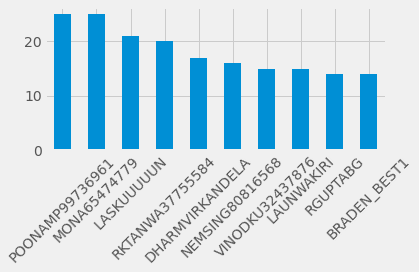

In [42]:
# visual representation of the out_degree
out_degree = graph.outDegrees.orderBy(col("outDegree").desc())
plt.style.use('fivethirtyeight')
ax = (out_degree.toPandas().head(10).plot(kind='bar', x='id', y='outDegree', legend=None))
ax.xaxis.set_label_text("")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Strongly Connected Components**

In [43]:
result = graph.stronglyConnectedComponents(maxIter=10)
(result.sort("component")
.groupby("component")
.agg(F.collect_list("id").alias("users")))

DataFrame[component: bigint, users: array<string>]

In [44]:
# SCC: every user is assigned to a unique component. This is the partition or subgroup they belongs to, 
# and as we see every user is in its own partition. 
#This means we have no circular dependencies
result.toPandas()

,id,text,mentions,component
0,ANNA_BOGGERO,"RT @vonderleyen: Second, we will ban the Kremlin’s media machine in the EU.\n \nThe state-owned Russia Today and Sputnik, and their subsidiar…",VONDERLEYEN,26
1,APRM718,RT @bdstans: Pay attention to Western leaders criticizing and dismissing ceasefire talks between #Ukraine and #Russia before they've even o…,BDSTANS,29
2,BERENICEDEVILLE,"RT @KersimonIsa: L'autocrate dynastique et islamiste tchétchène Kadyrov, homme-lige de Poutine malgré le massacre de Grozny en 1999, mobili…",KERSIMONISA,8589934658
3,ROGERVMORGAN,"@Ariesbo38129671 @SkyNews It’s not news, it’s propaganda during a time of information war here, and real war in Ukraine #UkraineRussiaWar",ARIESBO38129671,8589934965
4,NORDLICHER,"RT @juliaioffe: Friend after friend fleeing Russia. Five today alone. The best and the brightest, the journalists who were telling people t…",JULIAIOFFE,17179869487
...,...,...,...,...
111825,RUDDERS60,RT @PoliticsPollss: How well or badly do you think Liz Truss is handling the Ukraine crisis? #Politics #Government #Twitter #Poll,POLITICSPOLLSS,1700807049594
111826,RUDDERS60,RT @PoliticsPollss: Is the United Kingdom doing enough to support Ukraine? #Politics,POLITICSPOLLSS,1700807049594
111827,SYRIASONLINE,"RT @kit_knightly: While #SaudiArabia were dropping thousands of bombs on #Yemen they were not only ON the Human Rights Council, they were c…",KIT_KNIGHTLY,1700807049650
111828,SYRIASONLINE,"RT @snarwani: American in #Ukraine reports that the ""Zelensky regime"" has created ""chaos"" by handing out military-grade weapons to Ukrainia…",SNARWANI,1700807049650


<a id='5'></a>
## 5 Verified account prediction with classification algorithms

### Feature creation, selection and adaptation

#### Hastags
As aditional features, we'll indicate wether the three main hashtags are mentioned in the text of the tweet 

In [45]:
tags = (tweets
      .select(F.explode("entities.hashtags.text").alias("hashtag"))
      .groupBy("hashtag")
      .agg(F.count("*").alias("total"))
      .orderBy(F.desc("total"))
      .limit(15))

populars = [word for word in tags.limit(3).toPandas()["hashtag"]]

for hashtag in populars:
    tweets = (tweets.
              withColumn("string_hash", F.col("entities.hashtags.text").cast('string'))              
              .withColumn(f"{hashtag}", F.when(F.col("string_hash").like(f"{hashtag}"),1)
                      .otherwise(0)))
for hashtag in populars:
    print(hashtag)

Ukraine
Russia
UkraineRussiaWar


#### Levels
Then, we'll take the features of interest that are nested to the first level of the dataframe, in order to allow the code to use them.

In [46]:
tweets = (tweets
              .withColumn("followers", F.col("user.followers_count"))
              .withColumn("friends", F.col("user.friends_count"))
              .withColumn("favourites_count", F.col("user.statuses_count"))
              .withColumn("statuses_count", F.col("user.statuses_count"))
              .withColumn("verified", F.when(F.col("user.verified")== True,1)
                      .otherwise(0)))
              

We select the value to predict (label_column), and then define the categorical and numerical features

In [47]:
label_colum = "verified"
categoricalCols = ["lang"]
numericCols = ["statuses_count","favourites_count","friends",'followers']

### Pipeline elements 
#### String Indexer, OneHotEncoder and Vector Assambler

In [48]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.ml.feature import VectorAssembler

indexOutputCols = [x + "Index" for x in categoricalCols]

oheOutputCols = [x + "OHE" for x in categoricalCols]

stringIndexer = StringIndexer(inputCols=categoricalCols, outputCols=indexOutputCols,handleInvalid="skip")

oheEncoder = OneHotEncoder(inputCols=indexOutputCols,outputCols=oheOutputCols)

assemblerInputs = oheOutputCols + numericCols + populars
vecAssembler = VectorAssembler(inputCols=assemblerInputs,outputCol="features")

Next, we define the Pipeline with the previous elements

In [49]:
from pyspark.ml import Pipeline

test_pipeline = Pipeline(stages = [stringIndexer, oheEncoder, vecAssembler])
features_df = test_pipeline.fit(tweets).transform(tweets)
features_df.limit(2).toPandas()

,created_at,id_str,text,user,retweeted_status,place,quote_count,reply_count,retweet_count,favorite_count,...,Russia,UkraineRussiaWar,followers,friends,favourites_count,statuses_count,verified,langIndex,langOHE,features
0,2022-02-27 13:08:48,1497906560814796801,"RT @mbk_center: Putin's invasion of Ukraine🇺🇦 has sparked a host of anti-war demonstrations in cities around the world, including Russia 🇷🇺…","(716733642488299520, Abęfę🤴, abefe007, Ogun, Nigeria, Graphics Designer | Travel and Tour consultant | Man United Fan⚽ | Music Lover | Movie lover.... I always Follow Back✌️, 188, 1091, 0, 4075, 3347, Sun Apr 03 21:06:31 +0000 2016, False)","(None, 16, 107, 588, (80653307, Mikhail Khodorkovsky (English), mbk_center, London, Mikhail Khodorkovsky @mich261213 Twitter Account in English, 28401, 1664, 702, 17519, 35576, Wed Oct 07 19:03:44 +0000 2009))",None,0,0,0,0,...,0,0,188,1091,3347,3347,0,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 3347.0, 3347.0, 1091.0, 188.0, 0.0, 0.0, 0.0)"
1,2022-02-27 13:08:48,1497906561049583620,"RT @load_pm: 💪Зараз у Хмельницькому жінки та діти плетуть маскувальні сітки, щоб допомогти нашим героям. Всі українці, від малого до велико…","(803387388533899264, Piotr, Grado_Wwa, None, None, 1, 14, 0, 37, 7, Mon Nov 28 23:57:34 +0000 2016, False)","(None, 0, 1, 12, (1027991081584144386, nws, load_pm, UA Кременчук, 2022 Russian invasion of Ukraine, 1652, 14, 21, 108, 395, Fri Aug 10 18:52:27 +0000 2018))",None,0,0,0,0,...,0,0,1,14,7,7,0,5.0,"(0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 7.0, 14.0, 1.0, 0.0, 0.0, 0.0)"


### Selection of classificator algorithms

In [50]:
seed = 25

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.classification import LinearSVC

lr = LogisticRegression(labelCol="verified", featuresCol="features")
dt = DecisionTreeClassifier(labelCol="verified", featuresCol="features",seed=seed)
rf = RandomForestClassifier(labelCol="verified", featuresCol="features",maxDepth=10,seed=seed)
gbt = GBTClassifier(labelCol="verified", featuresCol="features",maxIter=10,seed=seed)
nb = NaiveBayes(labelCol="verified", featuresCol="features")
svm = LinearSVC(labelCol="verified", featuresCol="features")

classifiers = [lr,dt,rf,gbt,nb,svm]

#### Definition of the Pipeline

In [51]:
from pyspark.ml import Pipeline

def create_pipeline(classifier):
    return Pipeline(stages = [stringIndexer, oheEncoder, vecAssembler, classifier])

pipelines = [create_pipeline(classifier) for classifier in classifiers]

In [52]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol="verified",  metricName="accuracy")

### Sample of the data
Since we're trying to predict wether the account is verified or not, and considering that the proportion of verified accounts is small, we'll split the data in aproximately 50% of rows with verified users (taking all of them).

Then, we split in train and test set with a 80:20 proportion.

In [53]:
verified = tweets.where(F.col("verified")==1)
not_verified = tweets.where(F.col("verified")==0)
proportion = verified.count()/not_verified.count()

balanced = verified.unionByName(not_verified.sample(fraction=proportion))
balanced.count()

4560

In [54]:
(trainingData, testData) = balanced.randomSplit([0.8,0.2],seed=seed)

(trainingData1, testData1) = tweets.where("verified=0").randomSplit([0.8,0.2],seed=seed)
(trainingData2, testData2) = tweets.where("verified=1").randomSplit([0.8,0.2],seed=seed)

traininData = trainingData1.unionByName(trainingData2)
testData = testData1.unionByName(testData2)

###  Prediction and evaluation of the classificators

In [55]:
models = [pipeline.fit(trainingData) for pipeline in pipelines]
models

[PipelineModel_a224b3a622b1,
 PipelineModel_6e5c00cd7c4b,
 PipelineModel_2c4bac477e8c,
 PipelineModel_30af8e1b9ce2,
 PipelineModel_601eb053e1ad,
 PipelineModel_2b75f2b27601]

In [56]:
names = []
values = [] 
for model in models:
    prediction_df = model.transform(testData)
    accuracy = evaluator.evaluate(prediction_df)
    names.append(type(model.stages[-1]).__name__) # the algorithm is the last stage in the pipeline
    values.append(accuracy)

data = {'name':names,'accuracy':values,'model':models}
df = pd.DataFrame(data)
df.sort_values(by=['accuracy'], inplace=True, ascending=False)  
df

,name,accuracy,model
4,NaiveBayesModel,0.971451,PipelineModel_601eb053e1ad
0,LogisticRegressionModel,0.968938,PipelineModel_a224b3a622b1
5,LinearSVCModel,0.963204,PipelineModel_2b75f2b27601
2,RandomForestClassificationModel,0.913921,PipelineModel_2c4bac477e8c
3,GBTClassificationModel,0.905085,PipelineModel_30af8e1b9ce2
1,DecisionTreeClassificationModel,0.899274,PipelineModel_6e5c00cd7c4b
